In [1]:
import pandas as pd
import os
import glob
import dask.dataframe as dd
from dask import delayed
import numpy as np
@delayed
def process_file(file):
    df = pd.read_csv(file, index_col=0)
    df['TF'] = file.split('_')[-2]
    df['gender'] = file.split('_')[-3]
    df['term_idname'] = df['term_id'] + '_' + df['term_name']
    return df

/tmp/ipykernel_3760707/2506564632.py:4: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use a new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be reported on the Dask issue tracker
https://github.com/dask/dask/issues 

To disable this warning in the future, set dask config:

    # via Python
    >>> dask.config.set({'dataframe.query-planning-warning': False})

    # via CLI
    dask config set dataframe.query-p

In [2]:
df_moudule =  '/data2st1/junyi/output/atac0627/snregulation/genemodule.csv'
outdir ='/data2st1/junyi/output/atac0627/snregulation/gosummary_module'
df_TFstata = '/data1st1/yejun/long_neglog10p_merge.csv'
df_glob = glob.glob('/data2st1/junyi/output/atac0627/snregulation/gost/_GO*.csv')
meta=pd.read_csv('/data2st1/junyi/data/L2_anno_meta_add_mementovsmast.csv')
meta['celltype.L2'] = meta['L2'].str.replace(' ','_').str.replace('/','_')
l2nntype = dict(zip( meta['celltype.L2'],meta['Neurotransmitter_celltype']))
df_TF = pd.read_csv(df_moudule, index_col=0)

In [3]:
meta

,Unnamed: 0,Neurotransmitter_celltype,region,L2,count,gender,ct,ngr,rng,rgn,ngrc,rngc,rgnc,MementovsMast,celltype.L2
0,MOL-1_F,NN,ALL,MOL-1,20791,F,MOL-1_F,NN_ALL_F,ALL_NN_F,ALL_F_NN,NN_ALL_F_MOL-1,ALL_NN_F_MOL-1,ALL_F_NN_MOL-1,308,MOL-1
1,MOL-1_M,NN,ALL,MOL-1,20791,M,MOL-1_M,NN_ALL_M,ALL_NN_M,ALL_M_NN,NN_ALL_M_MOL-1,ALL_NN_M_MOL-1,ALL_M_NN_MOL-1,511,MOL-1
2,HPF DG GC Glut_M,Glut,HPF,HPF DG GC Glut,51928,M,HPF DG GC Glut_M,Glut_HPF_M,HPF_Glut_M,HPF_M_Glut,Glut_HPF_M_HPF DG GC Glut,HPF_Glut_M_HPF DG GC Glut,HPF_M_Glut_HPF DG GC Glut,1858,HPF_DG_GC_Glut
3,MOL-2_M,NN,ALL,MOL-2,13739,M,MOL-2_M,NN_ALL_M,ALL_NN_M,ALL_M_NN,NN_ALL_M_MOL-2,ALL_NN_M_MOL-2,ALL_M_NN_MOL-2,1231,MOL-2
4,PFC L2/3 IT Glut_F,Glut,PFC,PFC L2/3 IT Glut,43720,F,PFC L2/3 IT Glut_F,Glut_PFC_F,PFC_Glut_F,PFC_F_Glut,Glut_PFC_F_PFC L2/3 IT Glut,PFC_Glut_F_PFC L2/3 IT Glut,PFC_F_Glut_PFC L2/3 IT Glut,3636,PFC_L2_3_IT_Glut
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,STR Col8a1_Npas1 GABA_F,Gaba,STR,STR Col8a1_Npas1 GABA,251,F,STR Col8a1_Npas1 GABA_F,Gaba_STR_F,STR_Gaba_F,STR_F_Gaba,Gaba_STR_F_STR Col8a1_Npas1 GABA,STR_Gaba_F_STR Col8a1_Npas1 GABA,STR_F_Gaba_STR Col8a1_Npas1 GABA,0,STR_Col8a1_Npas1_GABA
438,VSMC_M,NN,ALL,VSMC,41,M,VSMC_M,NN_ALL_M,ALL_NN_M,ALL_M_NN,NN_ALL_M_VSMC,ALL_NN_M_VSMC,ALL_M_NN_VSMC,0,VSMC
439,HY Chol_M,Chol,HY,HY Chol,198,M,HY Chol_M,Chol_HY_M,HY_Chol_M,HY_M_Chol,Chol_HY_M_HY Chol,HY_Chol_M_HY Chol,HY_M_Chol_HY Chol,0,HY_Chol
440,MB Ucn_Chodl Glut_M,Glut,MB,MB Ucn_Chodl Glut,147,M,MB Ucn_Chodl Glut_M,Glut_MB_M,MB_Glut_M,MB_M_Glut,Glut_MB_M_MB Ucn_Chodl Glut,MB_Glut_M_MB Ucn_Chodl Glut,MB_M_Glut_MB Ucn_Chodl Glut,0,MB_Ucn_Chodl_Glut


In [3]:
df_TF_stata = pd.read_csv(df_TFstata, index_col=0)

In [4]:
# only select row in df_TF
df_TF_stata = df_TF_stata[df_TF_stata['TF'].isin(df_TF.index)]
#df_TF_stata['status'] = df_TF_stata['nlog10_p_val_adj'].sign() ,status is the 1 of the nlog10_p_val_adj > 0.05, -1 of the nlog10_p_val_adj < 0.05
df_TF_stata['status'] = np.sign(df_TF_stata['nlog10_p_val_adj'])
df_TF_stata = df_TF_stata.merge(df_TF, on='TF', how='left')
df_modulestat = df_TF_stata.groupby(['module','celltype']).aggregate({'nlog10_p_val_adj': 'mean', 'status': 'sum'}).reset_index()
df_modulestat['regulation'] = 0
df_modulestat.loc[df_modulestat['status'] > 0, 'regulation'] = 1
df_modulestat.loc[df_modulestat['status'] < 0, 'regulation'] = -1

In [8]:
modules = df_TF['module'].unique()

for module in modules:
    TF_module = df_TF[df_TF.module==module]
    # subset the file tha contains any tf in TFmodule.index
    filtered_list = [file for file in df_glob if any(tf in file for tf in TF_module.index)]

    # Create list of delayed objects
    delayed_dfs = [process_file(file) for file in filtered_list]

    # Convert to Dask DataFrame
    ddf = dd.from_delayed(delayed_dfs)

    # Compute result
    df_go_module = ddf.compute()

    df_go_module_group = df_go_module.groupby(['term_name','celltype','gender']).size().reset_index(name='count')
    df_go_module_group['celltype.gender'] = df_go_module_group['celltype'] + '_' + df_go_module_group['gender']
    df_go_module_group['module'] = module
    df_go_module_group =df_go_module_group.merge(df_modulestat, left_on=['celltype.gender','module'],right_on=['celltype','module'], how='left')
    df_go_module_group['reg_count'] = df_go_module_group['count'] * df_go_module_group['regulation']
    df_go_module_group.to_csv(os.path.join(outdir, f'{module}_gosummary.csv'), index=False)

In [ ]:
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/1_gosummary.csv |\
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/2_gosummary.csv |\
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/3_gosummary.csv |\
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/4_gosummary.csv ;
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/5_gosummary.csv |\
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/6_gosummary.csv |\
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/7_gosummary.csv |\
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/8_gosummary.csv ;

In [4]:
df_moudule1 = pd.read_csv("/data2st1/junyi/output/atac0627/snregulation/gosummary_module/1_gosummary.csv.predicted.csv")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


In [44]:
module_count.pivot('celltype.gender', 'predicted_module', 'reg_count')

/tmp/ipykernel_3760707/1481310959.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  module_count.pivot('celltype.gender', 'predicted_module', 'reg_count')


predicted_module,1,2,3,4,5,6,7,8,9,10,11
celltype.gender,,,,,,,,,,,
AMY_Ccdc3_Acvr1c_Glut_F,-31.0,-23.0,-38.0,-8.0,-2.0,-2.0,NaN,NaN,-4.0,-1.0,NaN
AMY_Ccdc3_Acvr1c_Glut_M,91.0,64.0,62.0,13.0,NaN,4.0,NaN,NaN,27.0,1.0,NaN
AMY_Cdh23_Hmcn1_Glut_F,-4.0,-15.0,-24.0,NaN,NaN,NaN,NaN,-12.0,NaN,NaN,NaN
AMY_Cdh23_Hmcn1_Glut_M,NaN,-5.0,-11.0,-2.0,NaN,NaN,NaN,-2.0,NaN,NaN,NaN
AMY_Foxp2_Penk_GABA_F,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
VLMC-2_M,8.0,8.0,8.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
VLMC-3_F,-13.0,-25.0,-29.0,NaN,-3.0,NaN,NaN,-3.0,NaN,NaN,NaN
VLMC-3_M,11.0,16.0,10.0,4.0,NaN,NaN,NaN,NaN,9.0,NaN,NaN


/tmp/ipykernel_3760707/2024869621.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  module_count = df_module.groupby(['predicted_module','celltype.gender']).sum()['reg_count'].reset_index()
/tmp/ipykernel_3760707/2024869621.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_t = module_count.pivot('celltype.gender', 'predicted_module', 'reg_count').T


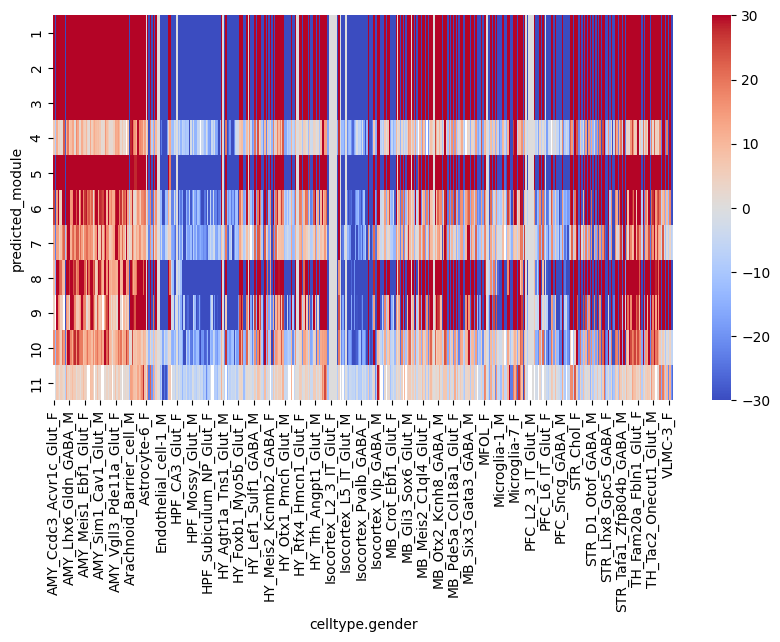

1     802
3     507
8     319
2     257
4     232
9     213
5     147
10    120
6     106
7      91
11     42
Name: predicted_module, dtype: int64


/tmp/ipykernel_3760707/2024869621.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  module_count = df_module.groupby(['predicted_module','celltype.gender']).sum()['reg_count'].reset_index()
/tmp/ipykernel_3760707/2024869621.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_t = module_count.pivot('celltype.gender', 'predicted_module', 'reg_count').T


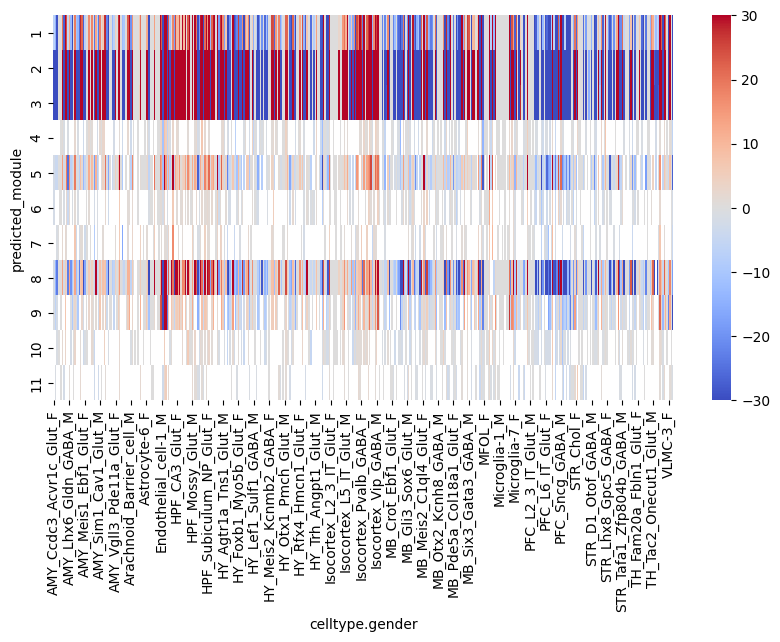

3     406
1     359
8     202
2     178
9     125
4     123
5     104
10     78
6      67
7      60
11     28
Name: predicted_module, dtype: int64


/tmp/ipykernel_3760707/2024869621.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  module_count = df_module.groupby(['predicted_module','celltype.gender']).sum()['reg_count'].reset_index()
/tmp/ipykernel_3760707/2024869621.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_t = module_count.pivot('celltype.gender', 'predicted_module', 'reg_count').T


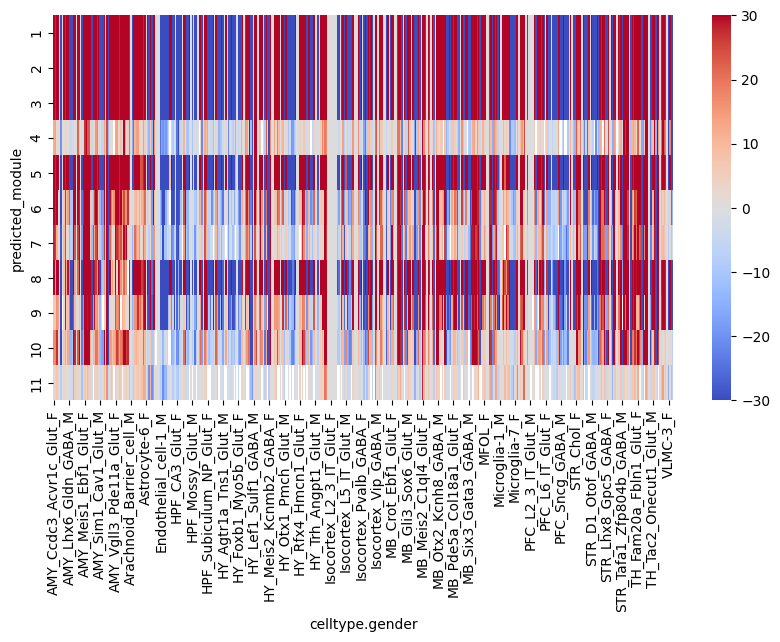

1     778
3     513
8     304
2     246
4     231
9     218
5     149
10    125
6     105
7      90
11     40
Name: predicted_module, dtype: int64


/tmp/ipykernel_3760707/2024869621.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  module_count = df_module.groupby(['predicted_module','celltype.gender']).sum()['reg_count'].reset_index()
/tmp/ipykernel_3760707/2024869621.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_t = module_count.pivot('celltype.gender', 'predicted_module', 'reg_count').T


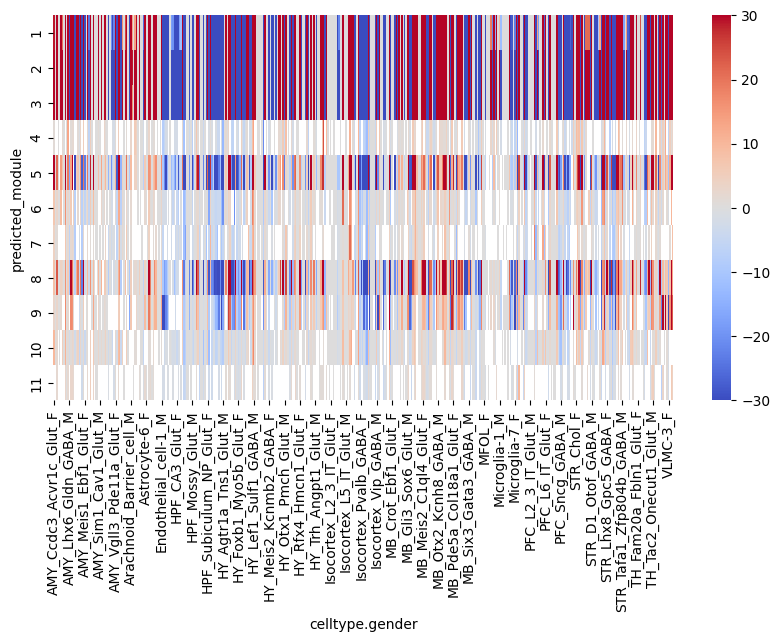

1     481
3     421
8     223
2     217
9     132
4     129
5     116
10     94
6      85
7      68
11     29
Name: predicted_module, dtype: int64


/tmp/ipykernel_3760707/2024869621.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  module_count = df_module.groupby(['predicted_module','celltype.gender']).sum()['reg_count'].reset_index()
/tmp/ipykernel_3760707/2024869621.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_t = module_count.pivot('celltype.gender', 'predicted_module', 'reg_count').T


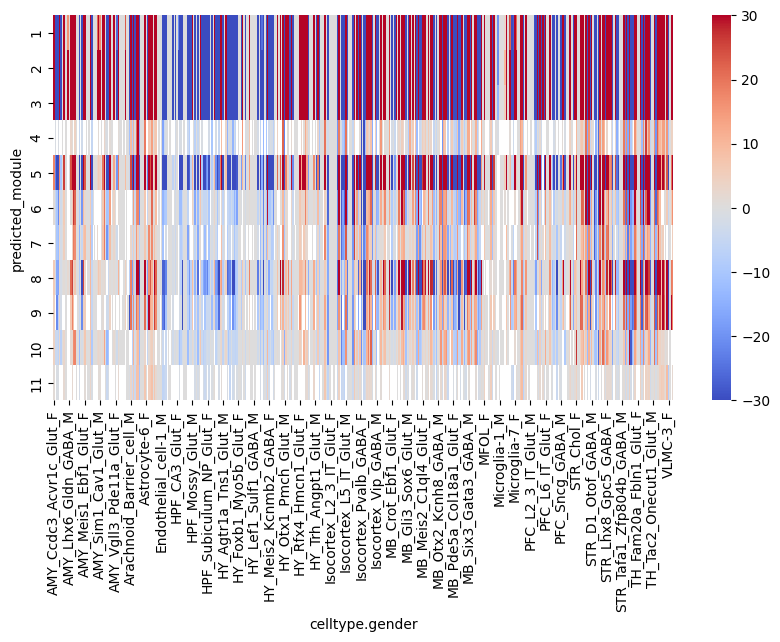

1     539
3     436
2     211
8     194
4     134
9     126
5     118
10    102
6      83
7      76
11     31
Name: predicted_module, dtype: int64


/tmp/ipykernel_3760707/2024869621.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  module_count = df_module.groupby(['predicted_module','celltype.gender']).sum()['reg_count'].reset_index()
/tmp/ipykernel_3760707/2024869621.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_t = module_count.pivot('celltype.gender', 'predicted_module', 'reg_count').T


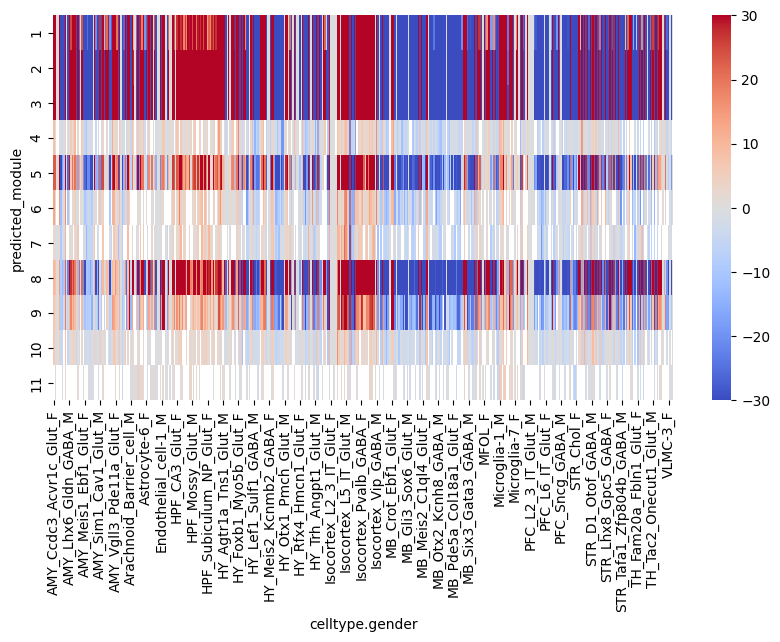

3     422
1     365
8     196
2     188
9     118
4     109
5     105
10     75
6      72
7      60
11     32
Name: predicted_module, dtype: int64


/tmp/ipykernel_3760707/2024869621.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  module_count = df_module.groupby(['predicted_module','celltype.gender']).sum()['reg_count'].reset_index()
/tmp/ipykernel_3760707/2024869621.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_t = module_count.pivot('celltype.gender', 'predicted_module', 'reg_count').T


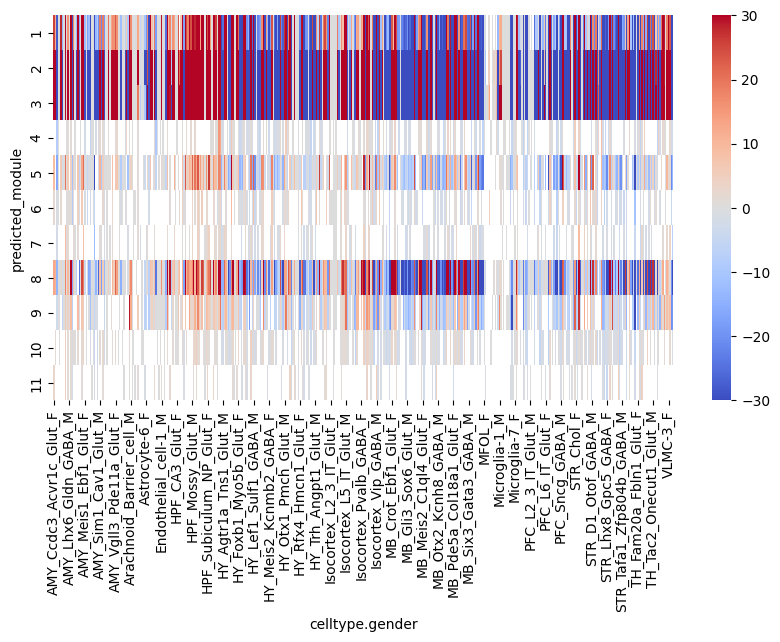

3     404
1     389
8     218
2     195
4     118
9     115
5      98
6      66
7      65
10     62
11     30
Name: predicted_module, dtype: int64


/tmp/ipykernel_3760707/2024869621.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  module_count = df_module.groupby(['predicted_module','celltype.gender']).sum()['reg_count'].reset_index()
/tmp/ipykernel_3760707/2024869621.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_t = module_count.pivot('celltype.gender', 'predicted_module', 'reg_count').T


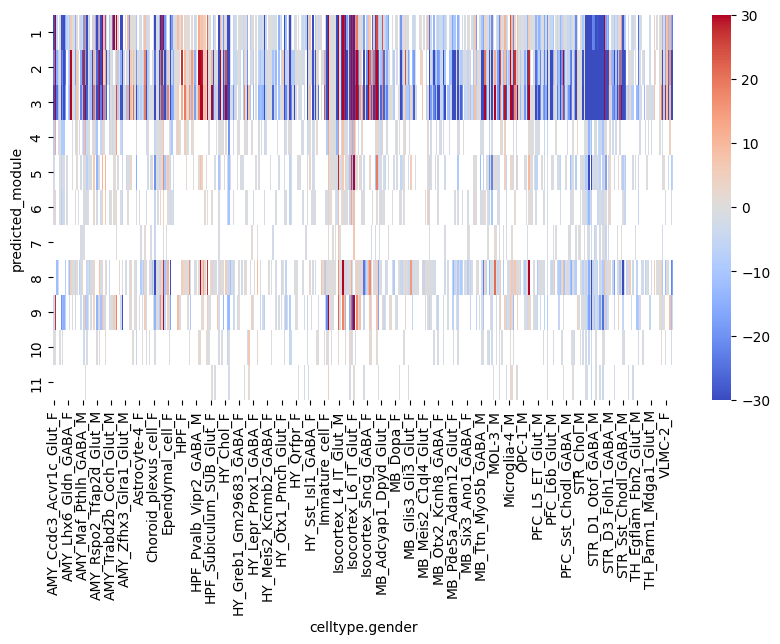

3     329
1     326
8     154
2     147
4     100
9      91
5      79
10     58
6      55
7      44
11     18
Name: predicted_module, dtype: int64


In [47]:
# plot the distribution of predicted_module
for module in range(1, 9):
    df_module = pd.read_csv(f"/data2st1/junyi/output/atac0627/snregulation/gosummary_module/{module}_gosummary.csv.predicted.csv")
    module_count = df_module.groupby(['predicted_module','celltype.gender']).sum()['reg_count'].reset_index()
    module_count = module_count[module_count['predicted_module'] != 12]
    # write csv
    module_count.to_csv(f"/data2st1/junyi/output/atac0627/snregulation/gosummary_module/{module}_gocount_gropup.csv", index=False)
    plt.figure(figsize=(10, 5))
    df_t = module_count.pivot('celltype.gender', 'predicted_module', 'reg_count').T
    df_t.to_csv(f"/data2st1/junyi/output/atac0627/snregulation/gosummary_module/{module}_gocount_gropup.pivot.csv")
    sns.heatmap(df_t, cmap='coolwarm', vmax=30, vmin=-30, center=0)
    plt.show()
    plt.close()
    print(df_module[df_module.predicted_module!=12].drop_duplicates('term_name')['predicted_module'].value_counts())